In [2]:
import eli5
import pandas as pd
import re
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [3]:
df = pd.read_csv('/Users/m.e.zubkova/Documents/diploma_final.csv')

In [4]:
male_names = pd.read_json('/Users/m.e.zubkova/Downloads/nlp-gender/male_names.json')
female_names = pd.read_json('/Users/m.e.zubkova/Downloads/nlp-gender/female_names.json')

In [5]:
def sex_classify(name: str):
    """Функция для определения гендера по имени"""
    if name in male_names.values:
        return 'male'
    if name in female_names.values:
        return 'female'
    return 'not in list of names'

In [6]:
# Извлекаем имя
df['freelancer_first_name'] = df.freelancer_name.apply(lambda name: name.split()[0])

In [7]:
# Классифицируем гендер имени
df['freelancer_gender'] = df.freelancer_first_name.apply(sex_classify)

Часть имен мы вручную вписали в словарь для определения пола большего числа фрилансеров.

In [8]:
# определим гендер для случаев, когда пользователи поменяли местами имя и фамилию

df.loc[
    (df['freelancer_gender'] == 'not in list of names'), 'freelancer_gender'
] = df.freelancer_name.apply(
    lambda name: sex_classify(name.split()[1]) if len(name.split()) > 1 else 'not in list of names')

In [9]:
df[df['freelancer_gender'] == 'not in list of names'].shape

# без гендера осталось 604 отзыва, их мы не будем учитывать в последующем анализе

(604, 7)

In [10]:
gendered = df[df['freelancer_gender'] != 'not in list of names']
gendered.freelancer_gender.value_counts()

female    6444
male      3781
Name: freelancer_gender, dtype: int64

In [11]:
gendered[gendered.texts != 'Нет отзыва'].freelancer_gender.value_counts()

female    5533
male      3447
Name: freelancer_gender, dtype: int64

In [12]:
def no_text(texts: pd.Series):
    """
    Функция подсчитывает долю отзывов без текста от всех отзывов (необходимо наличие оценки)
    """
    return len(texts[texts == 'Нет отзыва']) / len(texts)

In [13]:
gendered.groupby('freelancer_gender').agg({'texts': no_text})

# доля отзывов без текста у мужчин ниже, воспользуемся критерием хи-квадрат для проверки

,texts
freelancer_gender,
female,0.141372
male,0.088336


In [14]:
gendered['texts_existence'] = gendered.texts.apply(lambda text: text != 'Нет отзыва')
ct1 = pd.crosstab(gendered['freelancer_gender'], gendered['texts_existence'])
ct1

texts_existence,False,True
freelancer_gender,,
female,911,5533
male,334,3447


In [15]:
chi2_contingency(ct1)

# тест хи-квадрат показывает, что с вероятностью 99% наличие текста отзыва в отзывах на мужчин-фрилансеров и на женщин-фрилансерок различается

(62.182501680642176,
 3.130573149307869e-15,
 1,
 array([[ 784.62396088, 5659.37603912],
        [ 460.37603912, 3320.62396088]]))

In [16]:
# смотрим на оценки, в текстах, где фрилансеру не оставили отзыв в текстовом виде

gendered[gendered.texts == 'Нет отзыва'].groupby('freelancer_gender')['marks'].value_counts()

freelancer_gender  marks        
female             Пять с плюсом    458
                   5                366
                   4                 75
                   3                  7
                   2                  3
                   1                  2
male               Пять с плюсом    158
                   5                129
                   4                 37
                   3                  4
                   1                  3
                   2                  3
Name: marks, dtype: int64

In [17]:
# почистим датасет от текстов без отзывов

with_reviews = gendered[gendered.texts != 'Нет отзыва']

In [18]:
# импортируем стоп-слова для обработки текстовых отзывов

mystem = Mystem()
russian_stopwords = stopwords.words("russian")

In [19]:
# предобработаем тексты, очистив их от пунктуации и стоп-слов

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]

    return tokens

In [20]:
with_reviews['texts_preprocessed'] = with_reviews.texts.apply(preprocess_text)

In [21]:
# создадим множество имен

set_of_names = set(map(lambda x: x.lower(), female_names.T.values.tolist()[0])) | set(map(lambda x: x.lower(), male_names.T.values.tolist()[0]))

In [22]:
# проверим наличие имен в текстах отзывов

with_reviews['name_in_review'] = with_reviews.texts_preprocessed.apply(lambda text: len(set(text) & set_of_names) > 0)

In [23]:
ct2 = pd.crosstab(with_reviews['freelancer_gender'], with_reviews['name_in_review'])
ct2

name_in_review,False,True
freelancer_gender,,
female,3037,2496
male,2121,1326


In [24]:
chi2_contingency(ct2)

# тест хи-квадрат показывает, что с вероятностью 99% наличие имени в отзывах на мужчин-фрилансеров и на женщин-фрилансерок значимо различается

(38.06627389047619,
 6.838196863551224e-10,
 1,
 array([[3178.08619154, 2354.91380846],
        [1979.91380846, 1467.08619154]]))

In [25]:
# создаем список из отчеств
patronyms = list(set(with_reviews['freelancer_name'].apply(lambda name: name.split()[1] if len(name.split()) > 1 else None).values) - set(with_reviews.freelancer_first_name.values) - {None, '-', 'Chill&Work'})
len(patronyms)

165

In [26]:
def patronym(text: str):
    """Функция заменяет отчество в тексте отзыва"""
    for patronym in patronyms:
        if patronym in text:
            text = text.replace(patronym, '<patronym>')
    return text

In [27]:
with_reviews['texts'] = with_reviews.texts.apply(patronym)

In [28]:
# содержание отчества в текстах отзывов

ct3 = pd.crosstab(with_reviews['texts'].str.contains('<patronym>'), with_reviews.freelancer_gender)
ct3

freelancer_gender,female,male
texts,,
False,5453,3401
True,80,46


In [29]:
chi2_contingency(ct3)

(0.11843979552620007,
 0.7307328562170556,
 1,
 array([[5455.36547884, 3398.63452116],
        [  77.63452116,   48.36547884]]))

In [30]:
ct4 = pd.crosstab(with_reviews['marks'], [with_reviews.freelancer_gender, with_reviews['name_in_review']])
ct4

freelancer_gender female        male     
name_in_review     False  True False True
marks                                    
1                     91    37    60   10
2                     43    14    23   12
3                     20     7    13    4
4                     44     9    44   11
5                    947   687   743  360
Пять с плюсом       1892  1742  1238  929

In [31]:
chi2_contingency(ct4)

# среди мужских отзывов имена чаще встречаются в положительных отзывах

(136.4319108739594,
 1.1616787314219608e-21,
 15,
 array([[  66.96280624,   55.03429844,   46.76592428,   29.23697105],
        [  31.11403118,   25.5714922 ,   21.72962138,   13.58485523],
        [  14.88062361,   12.2298441 ,   10.39242762,    6.49710468],
        [  36.52516704,   30.01870824,   25.50868597,   15.94743875],
        [ 925.64242762,  760.7518931 ,  646.45623608,  404.14944321],
        [1961.87494432, 1612.39376392, 1370.14710468,  856.58418708]]))

In [32]:
# посмотрим на наличие слов, указывающих на гендер фрилансера в отзывах
gendered_words = ['девушка', 'женщина', 'мужчина']

In [33]:
with_reviews['gender_in_text'] = with_reviews.texts_preprocessed.apply(lambda tokens: len(set(tokens) & set(gendered_words)) != 0)

In [35]:
ct5 = pd.crosstab(with_reviews['freelancer_gender'], with_reviews['gender_in_text'])
ct5

gender_in_text,False,True
freelancer_gender,,
female,5348,185
male,3444,3


In [36]:
chi2_contingency(ct5)

# с вероятностью 99% встречаемость слов, указывающих на гендер фрилансеров в текстах отзывов, различается

(108.30396269347096,
 2.3056312449945537e-25,
 1,
 array([[5417.16436526,  115.83563474],
        [3374.83563474,   72.16436526]]))

In [37]:
# удалим имена из текстов отзывов

def del_name(tokens):
    return [token for token in tokens if token not in set_of_names]

In [38]:
with_reviews['texts_preprocessed'] = with_reviews['texts_preprocessed'].apply(del_name)

In [39]:
with_reviews.loc[with_reviews.marks == 'Пять с плюсом', 'marks'] = 6

In [40]:
with_reviews['marks'] = with_reviews.marks.astype(int)

In [41]:
with_reviews.groupby('freelancer_gender')['marks'].mean()

freelancer_gender
female    5.514007
male      5.491152
Name: marks, dtype: float64

Распределения оценок не различаются

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
with_reviews['texts_joined'] = with_reviews.texts_preprocessed.apply(lambda tokens: " ".join(tokens))

In [44]:
women = with_reviews[with_reviews.freelancer_gender == 'female'][['texts_joined', 'marks']]
men = with_reviews[with_reviews.freelancer_gender == 'male'][['texts_joined', 'marks']]

In [45]:
# построим бинарную логистическую регрессию, где объединим оценки 5 и 5+ в первый класс и 1-4 во второй класс

with_reviews['sentiment'] = 1
with_reviews.loc[with_reviews.marks.isin([1, 2, 3, 4]), 'sentiment'] = 0

In [46]:
with_reviews.sentiment.value_counts()

1    8538
0     442
Name: sentiment, dtype: int64

In [47]:
def has_cyrillic(text):
    """
    Проверяет, написано ли слово на кириллице
    """
    return bool(re.search('[а-яА-Я]', text))

In [48]:
def clean(text_tokenized):
    """
    Функция для выделения прилагательных в текстах отзывов (включает чистку от слов на латинице)
    """
    tokens = [token for token in text_tokenized if token.isalpha() and (token != ' ') and has_cyrillic(token) is True]
    tokens_res = []
    for token in tokens:
        try:
            if mystem.analyze(token)[0]['analysis'][0]['gr'].startswith('A='):
                tokens_res.append(token)
        except:
            pass
    return " ".join(tokens_res)

In [49]:
with_reviews['adjectives'] = with_reviews.texts_preprocessed.apply(clean)

In [50]:
women_bin = with_reviews[with_reviews.freelancer_gender == 'female'][['texts_joined', 'sentiment', 'adjectives']]
men_bin = with_reviews[with_reviews.freelancer_gender == 'male'][['texts_joined', 'sentiment', 'adjectives']]

In [60]:
from scipy.stats import ttest_rel

In [51]:
cv_f = CountVectorizer()
cv_fit_f = cv_f.fit_transform(women_bin.adjectives.values)
freqs_f = dict(zip(cv_f.get_feature_names(), np.asarray(cv_fit_f.sum(axis=0))[0]))

In [52]:
cv_m = CountVectorizer()
cv_fit_m = cv_m.fit_transform(men_bin.adjectives.values)
freqs_m = dict(zip(cv_m.get_feature_names(), np.asarray(cv_fit_m.sum(axis=0))[0]))

In [57]:
women_frame = pd.Series(dict(sorted(freqs_f.items(), key=lambda item: item[1], reverse=True))).to_frame().reset_index().rename(columns={0: 'female_freq', 'index': 'adjective'})
men_frame = pd.Series(dict(sorted(freqs_m.items(), key=lambda item: item[1], reverse=True))).to_frame().reset_index().rename(columns={0: 'male_freq', 'index': 'adjective'})

In [59]:
adjectives = women_frame.merge(men_frame, on='adjective', how='outer')
adjectives['share_f'] = adjectives.female_freq / sum(freqs_f.values())
adjectives['share_m'] = adjectives.male_freq / sum(freqs_m.values())
adjectives

,adjective,female_freq,male_freq,share_f,share_m
0,довольный,729.0,419.0,0.067034,0.068130
1,отличный,614.0,402.0,0.056460,0.065366
2,большой,599.0,317.0,0.055080,0.051545
3,хороший,529.0,314.0,0.048644,0.051057
4,огромный,329.0,219.0,0.030253,0.035610
...,...,...,...,...,...
1134,цитрусовый,NaN,1.0,NaN,0.000163
1135,чистоплотный,NaN,1.0,NaN,0.000163
1136,штатный,NaN,1.0,NaN,0.000163
1137,юморный,NaN,1.0,NaN,0.000163


In [62]:
adjectives['share/share'] = adjectives['share_f'] / adjectives['share_m']
adjectives.sort_values('share/share', ascending=False)

,adjective,female_freq,male_freq,share_f,share_m,share/share
98,милый,18.0,1.0,0.001655,0.000163,10.179310
108,конструктивный,16.0,1.0,0.001471,0.000163,9.048276
59,чуткий,34.0,3.0,0.003126,0.000488,6.409195
134,домашний,11.0,1.0,0.001011,0.000163,6.220690
138,верный,10.0,1.0,0.000920,0.000163,5.655172
...,...,...,...,...,...,...
1134,цитрусовый,NaN,1.0,NaN,0.000163,NaN
1135,чистоплотный,NaN,1.0,NaN,0.000163,NaN
1136,штатный,NaN,1.0,NaN,0.000163,NaN
1137,юморный,NaN,1.0,NaN,0.000163,NaN


In [228]:
from sklearn.naive_bayes import GaussianNB

In [64]:
x_train_mb, x_test_mb, y_train_mb, y_test_mb = train_test_split(men_bin.texts_joined, men_bin.sentiment, random_state=42)
x_train_fb, x_test_fb, y_train_fb, y_test_fb = train_test_split(women_bin.texts_joined, women_bin.sentiment, random_state=42)

In [65]:
vec_mb = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
vec_train_mb = vec_mb.fit_transform(x_train_mb)
vec_test_mb = vec_mb.transform(x_test_mb)


scaler_mb = MaxAbsScaler()
vec_train_mb = scaler_mb.fit_transform(vec_train_mb)
vec_test_mb = scaler_mb.transform(vec_test_mb)

In [302]:
grid_knn = {"n_neighbors": [1, 2, 3, 5, 8], "p": [1, 2]}
knn_m = KNeighborsClassifier()
knn_cv_m = GridSearchCV(knn_m, grid_knn, cv=5)
knn_cv_m.fit(vec_train_mb, y_train_mb)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5, 8], 'p': [1, 2]})

In [303]:
knn_cv_m.best_params_

{'n_neighbors': 1, 'p': 2}

In [304]:
knn_m = KNeighborsClassifier(n_neighbors=1, p=2)
knn_m.fit(vec_train_mb, y_train_mb)
knn_preds_m = knn_m.predict(vec_test_mb)

In [306]:
print(classification_report(knn_preds_m, y_test_mb))

              precision    recall  f1-score   support

           0       0.40      0.95      0.57        20
           1       1.00      0.97      0.98       842

    accuracy                           0.97       862
   macro avg       0.70      0.96      0.77       862
weighted avg       0.98      0.97      0.97       862



In [244]:
grid_naive = {"var_smoothing": [np.logspace(0,-9, num=10000)]}
naive_m = GaussianNB()
naive_cv = GridSearchCV(naive_m, grid_naive, cv=5)
naive_cv.fit(vec_train_mb.toarray(), y_train_mb)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [array([1.00000000e+00, 9.97929612e-01, 9.95863511e-01, ...,
       1.00415367e-09, 1.00207468e-09, 1.00000000e-09])]})

In [246]:
naive_m = GaussianNB(var_smoothing=naive_cv.best_params_['var_smoothing'])
naive_m.fit(vec_train_mb.toarray(), y_train_mb)
naive_pred_m = naive_m.predict(vec_test_mb.toarray())

In [247]:
print(classification_report(naive_pred_m, y_test_mb))

              precision    recall  f1-score   support

           0       0.72      0.27      0.40       124
           1       0.89      0.98      0.93       738

    accuracy                           0.88       862
   macro avg       0.81      0.63      0.67       862
weighted avg       0.87      0.88      0.86       862



In [66]:
grid = {"C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2", None],
        "solver": ['lbfgs', 'liblinear']} # l1 lasso l2 ridge
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5)
logreg_cv.fit(vec_train_mb, y_train_mb)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'liblinear']})

In [67]:
logreg_cv.best_params_

{'C': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [68]:
log_m = LogisticRegression(C=1000.0, penalty='l2', solver='lbfgs')
log_m.fit(vec_train_mb, y_train_mb)
preds_mb = log_m.predict(vec_test_mb)

In [69]:
print(classification_report(preds_mb, y_test_mb))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80        35
           1       1.00      0.98      0.99       827

    accuracy                           0.98       862
   macro avg       0.85      0.96      0.90       862
weighted avg       0.99      0.98      0.98       862



In [70]:
eli5.sklearn.explain_weights_sklearn(log_m, vec=vec_mb, top=100)

Weight?,Feature
+10.550,очень
+8.048,молодец
+7.835,быстро
+7.698,отлично
+7.170,отличный
+6.909,качественно
+6.490,спасибо
+5.543,оперативно
+5.289,хороший специалист
+5.247,понравиться


In [71]:
vec_fb = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
vec_train_fb = vec_fb.fit_transform(x_train_fb)
vec_test_fb = vec_fb.transform(x_test_fb)


scaler_fb = MaxAbsScaler()
vec_train_fb = scaler_fb.fit_transform(vec_train_fb)
vec_test_fb = scaler_fb.transform(vec_test_fb)

In [307]:
knn_f = KNeighborsClassifier()
knn_cv_f = GridSearchCV(knn_f, grid_knn, cv=5)
knn_cv_f.fit(vec_train_fb, y_train_fb)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5, 8], 'p': [1, 2]})

In [308]:
knn_cv_f.best_params_

{'n_neighbors': 1, 'p': 1}

In [309]:
knn_f = KNeighborsClassifier(n_neighbors=1, p=1)
knn_f.fit(vec_train_fb, y_train_fb)
knn_preds_f = knn_f.predict(vec_test_fb)

In [310]:
print(classification_report(knn_preds_f, y_test_fb))

              precision    recall  f1-score   support

           0       0.36      0.78      0.49        37
           1       0.99      0.96      0.98      1347

    accuracy                           0.96      1384
   macro avg       0.68      0.87      0.73      1384
weighted avg       0.98      0.96      0.96      1384



In [311]:
naive_f = GaussianNB()
naive_cv_f = GridSearchCV(naive_f, grid_naive, cv=5)
naive_cv_f.fit(vec_train_fb.toarray(), y_train_fb)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [array([1.00000000e+00, 9.97929612e-01, 9.95863511e-01, ...,
       1.00415367e-09, 1.00207468e-09, 1.00000000e-09])]})

In [312]:
naive_cv_f.best_params_

{'var_smoothing': array([1.00000000e+00, 9.97929612e-01, 9.95863511e-01, ...,
        1.00415367e-09, 1.00207468e-09, 1.00000000e-09])}

In [313]:
naive_f = GaussianNB(var_smoothing=naive_cv_f.best_params_['var_smoothing'])
naive_f.fit(vec_train_fb.toarray(), y_train_fb)
naive_pred_f = naive_f.predict(vec_test_fb.toarray())

In [314]:
print(classification_report(naive_pred_f, y_test_fb))

              precision    recall  f1-score   support

           0       0.54      0.26      0.35       168
           1       0.90      0.97      0.94      1216

    accuracy                           0.88      1384
   macro avg       0.72      0.62      0.64      1384
weighted avg       0.86      0.88      0.87      1384



In [72]:
logreg_f = LogisticRegression()
logreg_cv_f = GridSearchCV(logreg_f, grid, cv=5)
logreg_cv_f.fit(vec_train_fb, y_train_fb)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'liblinear']})

In [73]:
logreg_cv_f.best_params_

{'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [315]:
log_f = LogisticRegression(C=100, penalty='l1', solver='liblinear')
log_f.fit(vec_train_fb, y_train_fb)
preds_fb = log_f.predict(vec_test_fb)

In [316]:
print(classification_report(preds_fb, y_test_fb))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76        66
           1       0.99      0.98      0.99      1318

    accuracy                           0.97      1384
   macro avg       0.84      0.91      0.87      1384
weighted avg       0.98      0.97      0.98      1384



In [317]:
eli5.sklearn.explain_weights_sklearn(log_f, vec=vec_fb, top=100)

Weight?,Feature
+36.945,очень
+36.942,спасибо
+21.165,качественно
+15.786,отлично
+15.163,отличный
+13.439,быстро
+13.326,оперативно
+13.144,рекомендовать
+11.447,работа
+9.886,молодец


In [200]:
data_male_pos = with_reviews[(with_reviews.freelancer_gender == 'male') & (with_reviews.sentiment == 1)].texts_preprocessed.values
data_female_pos = with_reviews[(with_reviews.freelancer_gender == 'female') & (with_reviews.sentiment == 1)].texts_preprocessed.values
data_male_neg = with_reviews[(with_reviews.freelancer_gender == 'male') & (with_reviews.sentiment == 0)].texts_preprocessed.values
data_female_neg = with_reviews[(with_reviews.freelancer_gender == 'female') & (with_reviews.sentiment == 0)].texts_preprocessed.values

Обучение эмбеддингов

In [210]:
import gensim
from gensim.models import Word2Vec

In [78]:
data_male = with_reviews[with_reviews.freelancer_gender == 'male'].texts_preprocessed.values
data_female = with_reviews[with_reviews.freelancer_gender == 'female'].texts_preprocessed.values
data = with_reviews.texts_preprocessed.values

In [79]:
model1 = gensim.models.Word2Vec(data_male, min_count = 1, vector_size = 100, window = 5)
model2 = gensim.models.Word2Vec(data_female, min_count = 1, vector_size = 100, window = 5)
model3 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)

In [192]:
adj_w = list(map(lambda token: 'A=' in str(mystem.analyze(token)), model2.wv.__dict__['index_to_key']))
adj_m = list(map(lambda token: 'A=' in str(mystem.analyze(token)), model1.wv.__dict__['index_to_key']))

sum(adj_w) / len(model2.wv.__dict__['index_to_key']), sum(adj_m) / len(model1.wv.__dict__['index_to_key'])

(0.1616724738675958, 0.14541336353340883)

In [193]:
verbs_w = list(map(lambda token: 'V=' in str(mystem.analyze(token)), model2.wv.__dict__['index_to_key']))
verbs_m = list(map(lambda token: 'V=' in str(mystem.analyze(token)), model1.wv.__dict__['index_to_key']))
sum(verbs_w) / len(model2.wv.__dict__['index_to_key']), sum(verbs_m) / len(model1.wv.__dict__['index_to_key'])

(0.11202090592334495, 0.11370328425821065)

In [81]:
model3.wv.most_similar('девушка')

[('отзывчивый', 0.9946463704109192),
 ('вежливый', 0.9944597482681274),
 ('ответственный', 0.9916698932647705),
 ('внимательный', 0.991573691368103),
 ('общение', 0.9910182952880859),
 ('замечательный', 0.9895108938217163),
 ('грамотный', 0.9885914921760559),
 ('терпеливый', 0.9880792498588562),
 ('порядочный', 0.9879602193832397),
 ('хороший', 0.986396074295044)]

In [116]:
# количество отзывов со словом специалист при описании женщин
pd.Series(data_female).apply(lambda text: 'специалист' in text).sum()

1209

In [117]:
# количество отзывов со словом специалист при описании мужчин
pd.Series(data_male).apply(lambda text: 'специалист' in text).sum()

781

In [126]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

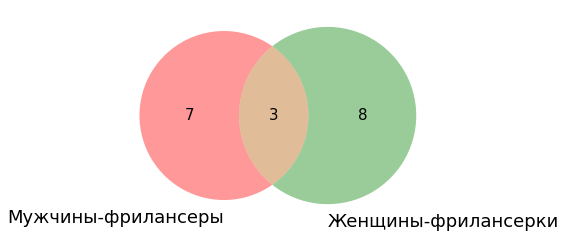

<Figure size 576x576 with 0 Axes>

Общие слова для двух моделей: {'советовать', 'рекомендовать', 'очень'}
Слова, ближайшие в векторных представлениях на мужских отзывах: {'работа', 'дизайнер', 'работать', 'четко', 'заказ', 'мастер', 'понравиться'}
Слова, ближайшие в векторных представлениях на женских отзывах: {'прекрасный', 'благодарить', 'отличный', 'прекрасно', 'ответственный', '!!!', 'приятно', 'супер'}


In [144]:
male = set(list(map(lambda x: x[0], model1.wv.most_similar('специалист'))))
female = set(list(map(lambda x: x[0], model2.wv.most_similar('специалист', topn=11))))

c = venn2([male, female], ('Мужчины-фрилансеры', 'Женщины-фрилансерки'))
plt.figure(figsize=(8,8))
plt.show()
print(f'Общие слова для двух моделей: {set(female) & set(male)}')
print(f'Слова, ближайшие в векторных представлениях на мужских отзывах: {set(male) - set(female)}')
print(f'Слова, ближайшие в векторных представлениях на женских отзывах: {set(female) - set(male)}')

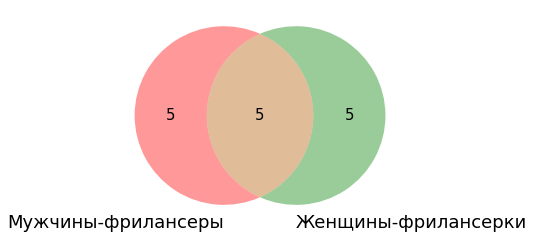

<Figure size 576x576 with 0 Axes>

Общие слова для единой выборки: человек, свой, дело, настоящий, мастер
Слова, ближайшие в векторных представлениях, построенных на мужских отзывах: хороший, работать, знать, обращаться, приятно
Слова, ближайшие в векторных представлениях, построенных на женских отзывах: прекрасный, общение, девушка, приятный, специалист


In [151]:
male = set(list(map(lambda x: x[0], model1.wv.most_similar('профессионал'))))
female = set(list(map(lambda x: x[0], model2.wv.most_similar('профессионал'))))

c = venn2([male, female], ('Мужчины-фрилансеры', 'Женщины-фрилансерки'))
plt.figure(figsize=(8,8))
plt.show()
print(f'Общие слова для единой выборки: {", ".join(list(set(female) & set(male)))}')
print(f'Слова, ближайшие в векторных представлениях, построенных на мужских отзывах: {", ".join(list(set(male) - set(female)))}')
print(f'Слова, ближайшие в векторных представлениях, построенных на женских отзывах: {", ".join(list(set(female) - set(male)))}')

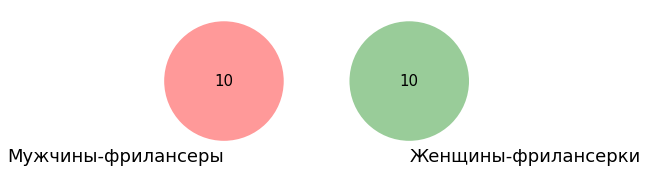

<Figure size 576x576 with 0 Axes>

Общие слова для единой выборки: 
Слова, ближайшие в векторных представлениях, построенных на мужских отзывах: человек, проект, хороший, дизайнер, получаться, клиент, стоимость, деньги, работать, время
Слова, ближайшие в векторных представлениях, построенных на женских отзывах: замечательный, прекрасный, девушка, грамотный, настоящий, отзывчивый, вежливый, ответственный, талантливый, профи


In [158]:
male = set(list(map(lambda x: x[0], model1.wv.most_similar('мастер'))))
female = set(list(map(lambda x: x[0], model2.wv.most_similar('мастер'))))

c = venn2([male, female], ('Мужчины-фрилансеры', 'Женщины-фрилансерки'))
plt.figure(figsize=(8,8))
plt.show()
print(f'Общие слова для единой выборки: {", ".join(list(set(female) & set(male)))}')
print(f'Слова, ближайшие в векторных представлениях, построенных на мужских отзывах: {", ".join(list(set(male) - set(female)))}')
print(f'Слова, ближайшие в векторных представлениях, построенных на женских отзывах: {", ".join(list(set(female) - set(male)))}')

In [195]:
# количество отзывов, где встречается слово мастер в женских отзывах

pd.Series(data_female).apply(lambda text: 'мастер' in text).sum()

206

In [162]:
# количество отзывов, где встречается слово мастер

pd.Series(data_male).apply(lambda text: 'мастер' in text).sum()

199